In [12]:
import numpy as np
from math import pi, sqrt, tanh
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy.optimize import minimize
import time
from ipywidgets import interact

In [13]:
hbar=1.05e-34
elec=1.6e-19
meV=elec*1e-3

vF=1e6
B=10 # Tesla
hwc=vF*sqrt(2*hbar*elec*B)
lB=np.sqrt(hbar/(elec*B))
m_sc=3*hwc #1e2*meV
mu_sc=0*hwc #1e2*meV
D1=0.*hwc #10*meV
D2=0.*hwc #10*meV
nu=0#sqrt(2)+0.1
mu_n=nu*hwc #10*meV
m_n=0.1*hwc

lRx= 1*hwc
lRy= 0.*hwc
lso= 0.*hwc
# lam=0.5*vF
gs=0.0*hwc
gn=0.3*hwc

ky_sw=np.linspace(-1,1,50)*4/lB

Ls=6*lB
Lx=8*lB
Nx=100
kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
[k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)


def y2(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c= np.exp(1j*k*Ls/2)*(-2j+np.exp(1j*k*Lx)*(2j+ 2*k*Lx- 1j* k**2 * Lx**2))/ (k**3) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**3 /(3*(2*Lx+Ls))
    return c

def y1(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx)*(1- 1j* k * Lx))/ (k**2) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**2 /(2*(2*Lx+Ls))
    return c

def y0(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = -1j*np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx) )/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Lx /(2*Lx+Ls)
    return c

def y0s(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = 2*np.sin(k*Ls/2)/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Ls /(2*Lx+Ls)
    return c

sigma0=np.array([[1,0],[0,1]])
sigma1=np.array([[0,1],[1,0]])
sigma2=np.array([[0,-1j],[1j,0]])
sigma3=np.array([[1,0],[0,-1]])
s00=np.kron(sigma0,sigma0)
s30=np.kron(sigma3,sigma0)
s01=np.kron(sigma0,sigma1)
s02=np.kron(sigma0,sigma2)


Hx= hbar*vF*np.kron(s30, np.kron(np.diag(kx) , sigma1))
HeB= 2j*vF*elec*B* np.kron(np.imag(y1(k1-k2)), sigma2)
HeBT= 2j*vF*elec*B* np.kron(np.imag(y1(k2-k1)), sigma2)

Hxm= np.kron( m_sc*y0s(k1-k2)+2*m_n*np.real(y0(k1-k2)) , sigma3)
HxmT= np.kron( m_sc*y0s(k2-k1)+2*m_n*np.real(y0(k2-k1)) , sigma3)
Hlx= np.kron(np.kron(sigma3,sigma2),np.kron( y0s(k1-k2) , lRx*sigma1)) #1
HlxT= np.kron(np.kron(sigma3,sigma2),np.kron( y0s(k2-k1) , lRx*sigma1)) #1
Hly= -np.kron(np.kron(sigma0,sigma1),np.kron( y0s(k1-k2) , lRy*sigma2)) #2
HlyT= -np.kron(np.kron(sigma0,sigma1),np.kron( y0s(k2-k1) , lRy*sigma2)) #2
Hlz= np.kron(np.kron(sigma3,sigma3),np.kron( y0s(k1-k2) , lso*sigma3)) # 333
HlzT= np.kron(np.kron(sigma3,sigma3),np.kron( y0s(k2-k1) , lso*sigma3))
Hl=Hlx+Hly+Hlz
HlT=HlxT+HlyT+HlzT
# Hlx=hbar*lam*np.kron(s02, np.kron( (k1+k2)/2*y0s(k1-k2),sigma0) )
# HlxT=-hbar*lam*np.kron(s02, np.kron((k1+k2)/2*y0s(k2-k1),sigma0) )

Hef= -np.kron( 2*mu_n*np.real(y0(k1-k2)) + mu_sc*y0s(k1-k2), sigma0 )
HefT= -np.kron( 2*mu_n*np.real(y0(k2-k1)) + mu_sc*y0s(k2-k1), sigma0 )

Hd= np.kron(y0s(k1-k2),sigma0)
# basis ud,ud
# dmat1=np.kron(np.array([[0.,1j],[0.,0.]]),sigma1)
# ddmat1=np.kron(dmat1,sigma2) 
dmat2=np.kron(np.array([[0.,1j],[0.,0.]]),D1*sigma1+D2*sigma0)
ddmat2=np.kron(dmat2,sigma2)
Hd_mat=np.kron(ddmat2,Hd)
Hd_mat=Hd_mat+np.transpose(Hd_mat).conj()

s03=np.kron(sigma0,sigma3)
Hz_up= -(gs*y0s(k1-k2)+2*gn*np.real(y0(k1-k2)))
Hz= np.kron(s03, np.kron(Hz_up,sigma0) )
Hz_upT= -(gs*y0s(k2-k1)+2*gn*np.real(y0(k2-k1)))
HzT= np.kron(s03, np.kron(Hz_upT,sigma0) )


Vn=np.zeros((16*Nx,16*Nx,len(ky_sw)), dtype=np.complex64)
En=np.zeros((16*Nx,len(ky_sw)))
for i_y in range(len(ky_sw)):
    ky=ky_sw[i_y]
    Hy= hbar*vF*ky*np.kron(np.eye(Nx), sigma2)

#     Hly=hbar*lam*ky*np.kron(s01, np.kron(y0s(k1-k2),sigma0) )
#     HlyT=-hbar*lam*ky*np.kron(s01, np.kron(y0s(k2-k1),sigma0) )

    H1 = Hx + np.kron(s00, Hy+ HeB + Hxm + Hef)+ Hz + Hl
    H1T = -Hx  + np.kron(s00,Hy+ (HeBT + HxmT + HefT).conj())+ (HzT+HlT).conj()

    H_t=block_diag(H1,-H1T)+Hd_mat
    En[:,i_y], Vn[:,:,i_y] =np.linalg.eigh(H_t)


print("Done!")

Done!


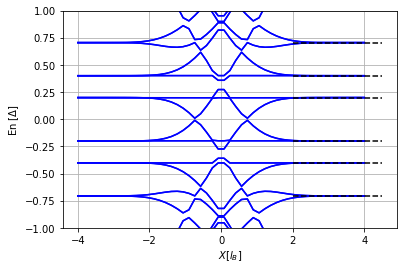

In [14]:
plt.figure()
plt.plot(ky_sw*lB,En.T/hwc,'b')
plt.ylabel(r"En [$\Delta$]")
plt.xlabel(r"$X[l_B]$")

Nll=4
ill=np.arange(Nll)
E1=np.reshape(np.sqrt(ill+(m_n/hwc)**2),[1,Nll])
Eplot= np.concatenate((E1,E1),axis=0)
xvals=np.reshape(np.array([2,4.5]),[2,1])
plt.plot(xvals, Eplot-mu_n/hwc-gn/hwc,'k--')
plt.plot(xvals, Eplot-mu_n/hwc+gn/hwc,'k--')
plt.plot(xvals, -Eplot+mu_n/hwc-gn/hwc,'k--')
plt.plot(xvals, -Eplot+mu_n/hwc+gn/hwc,'k--')


# plt.ylim(-22,22)
# plt.ylim(-0.015,0.015)
plt.ylim(-1,1)
plt.grid()

In [174]:
def wf_real_space(ev,k,x,Ls):
    Nx=len(k)
    kt=np.reshape(k,[1,Nx])
    xt=np.reshape(x,[len(x),1])
    
    ev_p= ev[:8*Nx,:]
    ev_p_K1 = ev_p[:4*Nx,:]
    ev_p_K2 = ev_p[4*Nx:,:]
    ev_h= ev[8*Nx:,:]
    ev_h_K1 = ev_h[:4*Nx,:]
    ev_h_K2 = ev_h[4*Nx:,:]
    ## uA # uB # dA # dB
    return np.dot(np.exp(1j*kt*xt),ev_p_K1[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K1[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K1[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K1[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K2[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K2[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K2[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K2[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K1[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K1[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K1[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K1[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K2[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K2[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K2[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K2[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0])


def plot_wf(i_band=Nx,iwf=int(len(ky_sw)/2)):
# iwf=0
    pyplot.figure(figsize=(10,10))
    pyplot.subplot(3,2,1)
    pyplot.plot(ky_sw*lB,En.T/hwc,'b')
    pyplot.plot(ky_sw[iwf]*lB,En[i_band,iwf]/hwc,'ro')
    pyplot.ylabel("Energy(meV)")
    pyplot.xlabel("X(l)")
    pyplot.ylim(-0.5,0.5)
    # pyplot.xlim(-7.5,7.5)
    pyplot.grid()
#     pyplot.show()

    x0=np.linspace(-1,1,500)*12*lB
    wfpK1_uA,wfpK1_uB, wfpK1_dA,wfpK1_dB,\
    wfpK2_uA,wfpK2_uB, wfpK2_dA,wfpK2_dB,\
    wfhK1_uA,wfhK1_uB, wfhK1_dA,wfhK1_dB,\
    wfhK2_uA,wfhK2_uB, wfhK2_dA,wfhK2_dB =wf_real_space(np.reshape(Vn[:,i_band,:],[16*Nx,len(ky_sw)]),kx,x0,Ls)
#     pyplot.figure()
    pyplot.title('ky=%.2f' % (ky_sw[iwf]*lB) )
    pyplot.subplot(3,2,3)
    pyplot.title('K1')
    pyplot.plot(x0/lB,np.abs(wfpK1_uA[:,iwf])**2,label=r'$eA\uparrow$')
    pyplot.plot(x0/lB,np.abs(wfpK1_uB[:,iwf])**2,label=r'$eB\uparrow$')
    pyplot.plot(x0/lB,np.abs(wfpK1_dA[:,iwf])**2,label=r'$eA\downarrow$')
    pyplot.plot(x0/lB,np.abs(wfpK1_dB[:,iwf])**2,label=r'$eB\downarrow$')

    pyplot.legend()
    pyplot.subplot(3,2,4)
    pyplot.title('K1')
    pyplot.plot(x0/lB,np.abs(wfhK1_uA[:,iwf])**2,label=r'$hA\uparrow$')
    pyplot.plot(x0/lB,np.abs(wfhK1_uB[:,iwf])**2,label=r'$hB\uparrow$')
    pyplot.plot(x0/lB,np.abs(wfhK1_dA[:,iwf])**2,label=r'$hA\downarrow$')
    pyplot.plot(x0/lB,np.abs(wfhK1_dB[:,iwf])**2,label=r'$hB\downarrow$')

    pyplot.legend()
    pyplot.subplot(3,2,5)
    pyplot.title('K2')
    pyplot.plot(x0/lB,np.abs(wfpK2_uA[:,iwf])**2,label=r'$eA\uparrow$')
    pyplot.plot(x0/lB,np.abs(wfpK2_uB[:,iwf])**2,label=r'$eB\uparrow$')
    pyplot.plot(x0/lB,np.abs(wfpK2_dA[:,iwf])**2,label=r'$eA\downarrow$')
    pyplot.plot(x0/lB,np.abs(wfpK2_dB[:,iwf])**2,label=r'$eB\downarrow$')

    pyplot.legend()
    pyplot.subplot(3,2,6)
    pyplot.title('K2')
    pyplot.plot(x0/lB,np.abs(wfhK2_uA[:,iwf])**2,label=r'$hA\uparrow$')
    pyplot.plot(x0/lB,np.abs(wfhK2_uB[:,iwf])**2,label=r'$hB\uparrow$')
    pyplot.plot(x0/lB,np.abs(wfhK2_dA[:,iwf])**2,label=r'$hA\downarrow$')
    pyplot.plot(x0/lB,np.abs(wfhK2_dB[:,iwf])**2,label=r'$hB\downarrow$')

    pyplot.legend()

    pyplot.show()

interact(plot_wf,iwf=(0,len(ky_sw)-1,1), i_band=range(8*Nx-int(nu**2)-5,8*Nx+int(nu**2)+5));
#, continuous_update=False);

interactive(children=(Dropdown(description='i_band', options=(795, 796, 797, 798, 799, 800, 801, 802, 803, 804…

SC spectrum